# Self-classifying Neural Cellular Automata (for Quick! Draw data).

This notebook contains a version of the [code](https://github.com/google-research/self-organising-systems/blob/master/notebooks/mnist_ca.ipynb) related to the Distill article on [Self-classifying MNIST Digits](https://distill.pub/2020/selforg/mnist/) and adapted for the [Quick! Draw](https://quickdraw.withgoogle.com/data) dataset.

This notebook is the "main" code of the project.

## Imports

In [18]:
import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFilter
import base64
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from math import sqrt
import json

import tensorflow as tf
from tensorflow.keras.layers import Conv2D

from IPython.display import Image, clear_output

## Image manipulation utilities

In [19]:
def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(PIL.Image(data=imencode(a, fmt)))

def drawing_to_image(drawing, size=52):
    """Converts a QuickDraw drawing (i.e. a list of strokes in from the .ndjson file) to a 52x52 grayscale image.
    """
    # create a blank white canvas
    canvas_size = 256
    image = PIL.Image.new("L", (canvas_size, canvas_size), color=255)
    draw = PIL.ImageDraw.Draw(image)
    
    # draw the strokes on the canvas
    for stroke in drawing:
        coords = list(zip(stroke[0], stroke[1]))
        for i in range(len(coords) - 1):
            draw.line([coords[i], coords[i+1]], fill=0, width=10)
    
    image = image.resize((size, size), resample=PIL.Image.LANCZOS)
    # we only care about bitmaps...
    image = image.convert("1")

    return image

def display_image_grid(images, n):
    """Display a nxn grid of images."""
    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            ax.imshow(images[i*n + j], cmap='gray')
            ax.axis('off')
    plt.show()

def tile2d(a, w=None):
    a = np.asarray(a)
    
    # Determine the width of the grid
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    
    th, tw = a.shape[1:3]
    
    # Pad the array to ensure it can be reshaped into a grid of width w
    pad = (w - len(a)) % w
    a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), 'constant')
    
    # Calculate the height of the grid
    h = len(a) // w
    
    # Reshape into a grid and reorder axes to prepare for final tiling
    a = a.reshape([h, w] + list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w] + list(a.shape[4:]))
    
    return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

## Model 

### Utilities and hyperparameters

In [3]:
CHANNEL_N = 10 # number of CA state channels
BATCH_SIZE = 16
POOL_SIZE = BATCH_SIZE * 10
CELL_FIRE_RATE = 0.5

ADD_NOISE = True

### Model definition

In [4]:
class CAModel(tf.keras.Model):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE,
               add_noise=ADD_NOISE):
    # CHANNEL_N does not include the greyscale channel, but it does include the 10 possible outputs.
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate
    self.add_noise = add_noise

    # unlike in the growing CA case, we make the kernels learnable!
    self.perceive = tf.keras.Sequential([
          Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
      ])

    self.dmodel = tf.keras.Sequential([
          Conv2D(80, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
                       kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n + 1]))  # dummy calls to build the model

  @tf.function
  def call(self, x, fire_rate=None, manual_noise=None):
    gray, state = tf.split(x, [1, self.channel_n], -1)
    ds = self.dmodel(self.perceive(x))
    if self.add_noise:
      if manual_noise is None:
        residual_noise = tf.random.normal(tf.shape(ds), 0., 0.02)
      else:
        residual_noise = manual_noise
      ds += residual_noise

    if fire_rate is None:
      fire_rate = self.fire_rate

    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    living_mask = gray >= 1.0 # cause bitmaps
    residual_mask = update_mask & living_mask
    ds *= tf.cast(residual_mask, tf.float32)
    state += ds
    
    return tf.concat([gray, state], -1)

  @tf.function
  def initialize(self, images):
    state = tf.zeros([tf.shape(images)[0], 52, 52, self.channel_n])
    images = tf.reshape(images, [-1, 52, 52, 1])
    return tf.concat([images, state], -1)

  @tf.function
  def classify(self, x):
    # The last 2 layers are the classification predictions, one channel
    # per class. Keep in mind there is no "background" class,
    # and that any loss doesn't propagate to "dead" pixels.
    return x[:,:,:,-2:]

In [5]:
CAModel().perceive.summary()

2023-08-17 16:40:56.780485: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-17 16:40:56.780506: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-17 16:40:56.780511: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-17 16:40:56.780540: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-17 16:40:56.780557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1, 3, 3, 80)             8000      
                                                                 
Total params: 8000 (31.25 KB)
Trainable params: 8000 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-08-17 16:40:57.021153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [6]:
CAModel().dmodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (1, 3, 3, 80)             6480      
                                                                 
 conv2d_5 (Conv2D)           (1, 3, 3, 10)             810       
                                                                 
Total params: 7290 (28.48 KB)
Trainable params: 7290 (28.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-08-17 16:40:57.138579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Training

### Training preparation

In [7]:
class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

In [8]:
# TODO maybe add evaluation (later)?

### Data manipulation and examination

In [9]:
# download the data from the google servers
%run utils/quickdraw_downloader.py --dir quickdraw_data --clean circle
%run utils/quickdraw_downloader.py --dir quickdraw_data --clean square


[+] downloading circle data... 100%
[+] download complete!
[+] cleaning up circle data...
[+] circle data cleaned successfully.

[+] downloading square data... 100%
[+] download complete!
[+] cleaning up square data...
[+] square data cleaned successfully.


In [10]:
#! I assume the data has already been downloaded, if you haven't done it already, use the 'quickdraw_downloader' script
data_dir = "quickdraw_data/"

Let's take a look at some drawings!

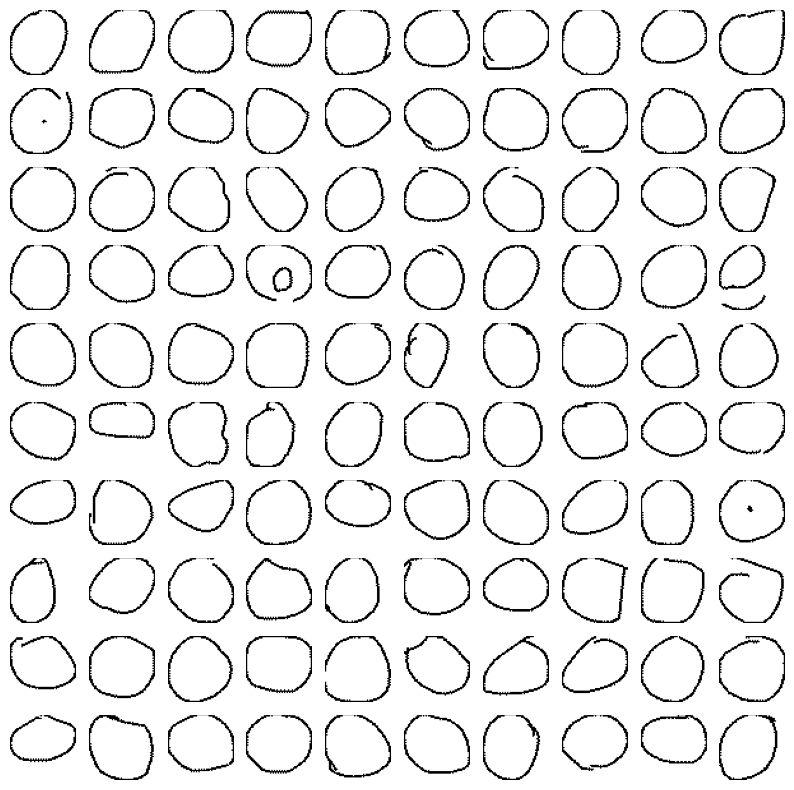

In [11]:
images = []
i = 0 # to avoid loading the whole dataset
with open(data_dir + "circle.ndjson", "r") as file:
    for line in file:
        i += 1
        data = json.loads(line)
        image = drawing_to_image(data["drawing"])
        images.append(image)
        if i > 100:
            break
        # image.show()  

display_image_grid(images, int(sqrt(i)))

All good! Now we need to split the file, to more easily access training, validation and testing data.

In [12]:
# split the data into training, validation and testing
%run utils/split_data.py square.ndjson
%run utils/split_data.py circle.ndjson


[+] commencing splitting of quickdraw_data/square.ndjson...
[+] splitting complete.

[+] commencing splitting of quickdraw_data/circle.ndjson...
[+] splitting complete.


In [13]:
def load_quickdraw_data(categories, dataset_types, base_dir, image_function):
    """Load QuickDraw data from .ndjson files, convert drawings to images and return them."""
    data = {}
    
    for category in categories:
        data[category] = {}
        for dtype in dataset_types:
            file_path = os.path.join(base_dir, f"{dtype}_{category}.ndjson")
            with open(file_path, 'r') as file:
                images = []
                for line in file:
                    draw_data = json.loads(line)
                    image = image_function(draw_data["drawing"])
                    images.append(image)
                data[category][dtype] = images

    return data

categories = ['circle', 'square']
dataset_types = ['train', 'val', 'test']

#! this might take a while
data = load_quickdraw_data(
    categories, dataset_types, data_dir, drawing_to_image)

In [14]:
x_train_circle = data['circle']['train']
x_train_square = data['square']['train']
x_test_circle = data['circle']['test']
x_test_square = data['square']['test']
x_val_circle = data['circle']['val']
x_val_square = data['square']['val']

x_train = x_train_circle + x_train_square
x_test = x_test_circle + x_test_square
x_val = x_val_circle + x_val_square

y_train = [0] * len(x_train_circle) + [1] * len(x_train_square)  # 0 for circle, 1 for square
y_test = [0] * len(x_test_circle) + [1] * len(x_test_square)
y_val = [0] * len(x_val_circle) + [1] * len(x_val_square)

x_train = [np.array(img, dtype=np.float32) for img in x_train]
x_test = [np.array(img, dtype=np.float32) for img in x_test]
x_val = [np.array(img, dtype=np.float32) for img in x_val]

In [15]:
len(x_train_circle), len(x_train_square) # pretty balanced, that's very good!

(83176, 84237)

In [17]:
color_lookup = tf.constant([
    [128, 0, 0],     
    [0, 128, 128],   

    [0, 0, 0], # shape default
    [255, 255, 255], # background
])

def color_labels(x, y_pic, dtype=tf.uint8):
    # determine where the drawing exists (i.e., black pixels)
    is_black = tf.cast(x == 0, tf.float32)
    is_white = tf.cast(x == 1, tf.float32) + 0.1

    y_pic = y_pic * tf.expand_dims(is_black, -1)  # apply colors only where the drawing exists.

    color_layer = tf.concat([y_pic, tf.stack([is_black, is_white], -1)], -1)

    rgb = tf.gather(color_lookup, tf.argmax(color_layer, -1))
    if dtype == tf.uint8:
        return tf.cast(rgb, tf.uint8)
    else:
        return tf.cast(rgb, dtype) / 255.

def to_binary_label(x, y):
    """Convert to binary labels for circle and square."""
    y_res = np.zeros(list(x.shape) + [2])
    for i, label in enumerate(y):
        y_res[i, x[i] == 0, label] = 1.0
    return y_res.astype(np.float32)

def find_different_shapes(x_set, y_set, y_set_pic, orientation="vertical"):
    result_y = []
    result_x = []
    for i in range(2):
        for x, y, y_pic in zip(x_set, y_set, y_set_pic):
            if y == i:
                result_y.append(color_labels(x, y_pic))
                result_x.append(x)
                break
    assert len(result_y) == 2

    result_y = np.concatenate(result_y, axis=0 if orientation == "vertical" else 1)
    result_x = np.stack(result_x)

    return result_y, result_x

y_train_pic = to_binary_label(x_train, y_train)
y_test_pic = to_binary_label(x_test, y_test)

shapes_legend_horiz, _ = find_different_shapes(x_train, y_train, y_train_pic, "horizontal")

imshow(zoom(shapes_legend_horiz))

AttributeError: 'list' object has no attribute 'shape'

In [17]:
# TODO maybe add generate_tiled_figures?
def classify_and_color(ca, x):
  colored_result = color_labels(x=x[:,:,:,0], y_pic=ca.classify(x), dtype=tf.float32)
  return colored_result
  
def generate_pool_figures(ca, pool, step_i):
  tiled_pool = tile2d(classify_and_color(ca, pool.x))
  ones = np.ones((72, 3))
  tiled_pool[:, :72, :] += (-tiled_pool[:, :72, :] + ones[None, :])
  tiled_pool[:, -72:, :] += (-tiled_pool[:, -72:, :] + ones[None, :])
  tiled_pool[:72, :, :] += (-tiled_pool[:72, :, :] + ones[:, None])
  tiled_pool[-72:, :, :] += (-tiled_pool[-72:, :, :] + ones[:, None])
  imwrite('train_log/%04d_pool.jpg' % step_i, tiled_pool)

def visualize_batch(ca, x0, x, step_i):
  vis0 = np.hstack(classify_and_color(ca, x0).numpy())
  vis1 = np.hstack(classify_and_color(ca, x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def individual_l2_loss(model, x, y):
  t = y - model.classify(x)
  return tf.reduce_sum(t**2, [1, 2, 3]) / 2

def batch_l2_loss(model, x, y):
  return tf.reduce_mean(individual_l2_loss(model, x, y))

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.5)
  pl.show()

Let's finally wrap up the preparations, define our model and initialise training!

In [18]:
ca = CAModel()

loss_log = []

lr = 1e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [700, 1200], [lr, lr*0.1, lr*0.01])
trainer = tf.keras.optimizers.legacy.Adam(lr_sched)

starting_indexes = np.random.randint(0, x_train.shape[0] - 1, size=POOL_SIZE)
pool = SamplePool(x=ca.initialize(x_train[starting_indexes]).numpy(), 
                  y=y_train_pic[starting_indexes])

2023-08-17 16:30:04.673462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-17 16:30:04.759629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [20]:
ca.classify(x_train[1])

ValueError: in user code:

    File "/var/folders/m2/j205f6kd4lsc468zllr25wbw0000gn/T/ipykernel_6359/2556445179.py", line 56, in classify  *
        return x[:,:,:,-2:]

    ValueError: Index out of range using input dim 2; input has only 2 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=7, ellipsis_mask=0, end_mask=15, new_axis_mask=0, shrink_axis_mask=0](x, strided_slice/stack, strided_slice/stack_1, strided_slice/stack_2)' with input shapes: [52,52], [4], [4], [4] and with computed input tensors: input[3] = <1 1 1 1>.


In [21]:
x_train[1]

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157]], dtype=float32)

In [72]:
!mkdir -p train_log && rm -f train_log/*

### Training loop

batch (before/after):


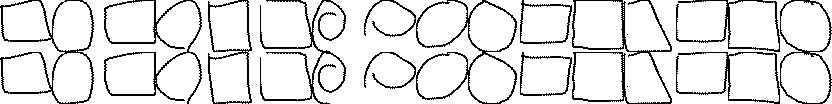

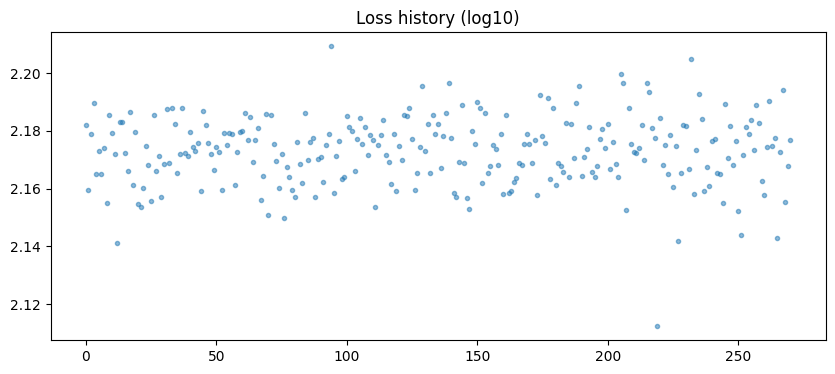

 step: 279, log10(loss): 2.194

KeyboardInterrupt: 

In [71]:
@tf.function
def train_step(x, y):
    iter_n = 20
    with tf.GradientTape() as g:
        for i in tf.range(iter_n):
            x = ca(x)
        loss = batch_l2_loss(ca, x, y)
    grads = g.gradient(loss, ca.weights)
    grads = [g/(tf.norm(g)+1e-8) for g in grads]
    trainer.apply_gradients(zip(grads, ca.weights))
    return x, loss

for i in range(1, 8000+1):
    # sample from pool
    batch = pool.sample(BATCH_SIZE)
    x0 = np.copy(batch.x)
    y0 = batch.y

    # update half of the batch with new data
    q_bs = BATCH_SIZE // 4

    # first quarter: completely new samples
    new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
    x0[:q_bs] = ca.initialize(x_train[new_idx])
    y0[:q_bs] = y_train_pic[new_idx]

    # last quarter: also completely new samples
    new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
    x0[-q_bs:] = ca.initialize(x_train[new_idx])
    y0[-q_bs:] = y_train_pic[new_idx]

    x, loss = train_step(x0, y0)

    # update pattern pool
    batch.x[:] = x
    batch.y[:] = y0  # reorder
    batch.commit()

    step_i = len(loss_log)
    loss_log.append(loss.numpy())

    if step_i % 50 == 0:
        generate_pool_figures(ca, pool, step_i)
    if step_i % 50 == 0:
        clear_output()
        visualize_batch(ca, x0, x, step_i)
        plot_loss(loss_log)

    print('\r step: %d, log10(loss): %.3f' % (len(loss_log), np.log10(loss)), end='')

In [ ]:
# TODO evaluation, possibly?